In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/scottduda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/scottduda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Import Libraries & Load Data

In [2]:
import numpy as np
import pandas as pd 

import os
import re
import string
import random
import time
import datetime

from collections import Counter
import itertools
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('bmh')

pd.set_option('display.max_rows', 100)

In [3]:
story_df = pd.read_csv('poe_short_stories.csv')
poem_line_df = pd.read_csv('poe_poems_lines.csv')
poem_stanza_df = pd.read_csv('poe_poems_stanzas.csv')

poem_line_df = poem_line_df.fillna('')
poem_stanza_df = poem_stanza_df.fillna('')

In [4]:
story_df.head()

,title,text,wikipedia_title,publication_date,first_published_in,classification,notes,normalized_date
0,A DESCENT INTO THE MAELSTRÖM,"The ways of God in Nature, as in Providence, a...",A Descent into the Maelström,May 1841,Graham's Magazine,Adventure,?,May 1841
1,A PREDICAMENT,"What chance, good lady, hath bereft you thus? ...",A Predicament,November 1838,Baltimore American Museum,Parody,"Companion to ""How to Write a Blackwood Article...",November 1838
2,A TALE OF JERUSALEM,Intensos rigidarn in frontern ascendere canos ...,A Tale of Jerusalem,"June 9, 1832",Philadelphia Saturday Courier,Humor,?,June 1832
3,A TALE OF THE RAGGED MOUNTAINS,"DURING the fall of the year 1827, while residi...",A Tale of the Ragged Mountains,April 1844,Godey's Lady's Book,"Adventure,Science_fiction",?,April 1844
4,BERENICE,"Dicebant mihi sodales, si sepulchrum amicae vi...",Berenice,March 1835,Southern Literary Messenger,Horror,?,March 1835


In [5]:
poem_line_df.head()

,title,line_text
0,The Raven,"Once upon a midnight dreary, while I pondered,..."
1,The Raven,Over many a quaint and curious volume of forgo...
2,The Raven,"While I nodded, nearly napping, suddenly there..."
3,The Raven,As of some one gently rapping—rapping at my ch...
4,The Raven,"""'Tis some visitor,"" I muttered, ""tapping at m..."


In [6]:
poem_stanza_df.head()

,title,stanza_text
0,The Raven,"Once upon a midnight dreary, while I pondered,..."
1,The Raven,"Ah, distinctly I remember, it was in the blea..."
2,The Raven,And the silken sad uncertain rustling of each...
3,The Raven,Presently my soul grew stronger; hesitating t...
4,The Raven,"Deep into that darkness peering, long I stood..."


# Clean Short Story Data

In [7]:
story_df[story_df.classification=='Essay']

,title,text,wikipedia_title,publication_date,first_published_in,classification,notes,normalized_date
62,* PHILOSOPHY OF FURNITURE,"In the internal decoration, if not in the exte...",?,May 1840,?,Essay,?,May 1840
63,MAELZEL’S CHESS-PLAYER,PERHAPS no exhibition of the kind has ever eli...,?,April 1836,?,Essay,?,April 1836
64,OLD ENGLISH POETRY,IT should not be doubted that at least one-thi...,?,?,?,Essay,?,?
67,THE POETIC PRINCIPLE,"IN speaking of the Poetic Principle, I have no...",?,"August 17, 1849",?,Essay,?,August 1849


In [8]:
# remove essays (non-fiction)
story_df = story_df.loc[story_df['classification'] != 'Essay'].reset_index()

In [9]:
story_df.shape

(66, 9)

In [10]:
story_df[story_df.normalized_date == '? 1843']

,index,title,text,wikipedia_title,publication_date,first_published_in,classification,notes,normalized_date
48,48,THE PIT AND THE PENDULUM,Impia tortorum longos hic turba furores Sangui...,The Pit and the Pendulum,? 1843,The Gift: A Christmas and New Year's Present,Horror,?,? 1843


"Annual issues were published in the fall of the preceding year.  The month for publication of this issue is thought to be October due to a reprint of "The Pit and the Pendulum" in the October 22, 1842 New York Spectator"

Source:  http://www.isfdb.org/cgi-bin/pl.cgi?296127

In [11]:
story_df.loc[story_df['title'] == 'THE PIT AND THE PENDULUM', 'normalized_date'] = 'October 1842'

In [12]:
story_df[story_df.normalized_date == '? 1841']

,index,title,text,wikipedia_title,publication_date,first_published_in,classification,notes,normalized_date
6,6,ELEONORA,Sub conservatione formae specificae salva anim...,Eleonora,? 1841,The Gift for 1842,Romance,?,? 1841


Since Eleonara appeared in the same publication (The Gift) as The Pit and the Pendulum, we can assume it had a similar date of publication (October of the previous year)

In [13]:
story_df.loc[story_df['title'] == 'ELEONORA', 'normalized_date'] = 'October 1841'

# Analyze Data

## Short Stories

In [14]:
story_df['normalized_date'] = pd.to_datetime(story_df['normalized_date'], format='%B %Y')

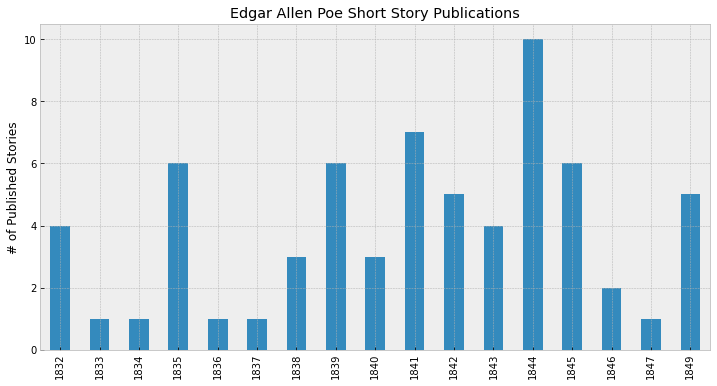

In [15]:
plt.figure(figsize=(12,6))
story_df.groupby(story_df['normalized_date'].dt.year)['index'].count().plot(kind='bar')
plt.title('Edgar Allen Poe Short Story Publications')
plt.xlabel('')
plt.ylabel('# of Published Stories')
plt.show()

In [16]:
# helper function for cleaning text

def clean_text(text):
    text = re.sub('\n', ' ', text)
    text = text.strip().lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join(text.split())
    text = text.strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('-', ' ', text)
    text = re.sub('“', '', text)
    text = re.sub('”', '', text)
    text = re.sub('—', ' ', text)
    text = re.sub("’", '', text)
    text = re.sub("‘", '', text)
    return text

In [17]:
# combine text

combined_text = ' '.join(story_df['text'].values)

In [18]:
stop_words = stopwords.words('english')

def get_ngrams(input, n):
    return [tuple(input[i:i+n]) for i in range(len(input) - n + 1)]

In [19]:
def plot_top_ngrams(data_series, stopwords, title='', n=1):
    if n == 1:
        ngram_list = list(itertools.chain(*data_series.apply(lambda x: word_tokenize(clean_text(x)))))
    else:
        ngram_list = list(itertools.chain(*data_series.apply(lambda x: get_ngrams(word_tokenize(clean_text(x)), n))))

    ngram_list = [x for x in ngram_list if x not in stopwords]
    ngram_list = [x for x in ngram_list if x != '']
    ngram_freq = Counter(ngram_list)
                          
    top_10_ngram = ngram_freq.most_common()[:10]
    if n == 1:
        top_ngrams = [x[0] for x in top_10_ngram]
    else:
        top_ngrams = [' '.join(x[0]) for x in top_10_ngram]
    top_ngram_counts = [x[1] for x in top_10_ngram]

    fig, ax = plt.subplots(figsize=(10,8))

    ax.barh(top_ngrams, top_ngram_counts, color='red')
    ax.set(title=title)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel='Number of Uses', labelpad=20)
    plt.show()

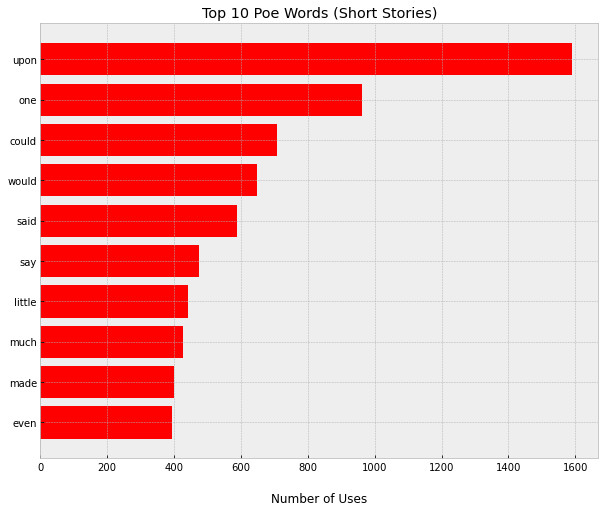

In [20]:
plot_top_ngrams(story_df.text, stop_words, title='Top 10 Poe Words (Short Stories)', n=1)

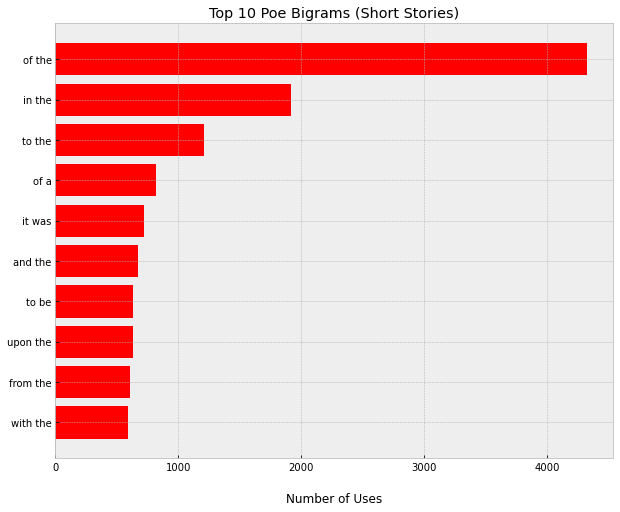

In [21]:
plot_top_ngrams(story_df.text, stop_words, title='Top 10 Poe Bigrams (Short Stories)', n=2)

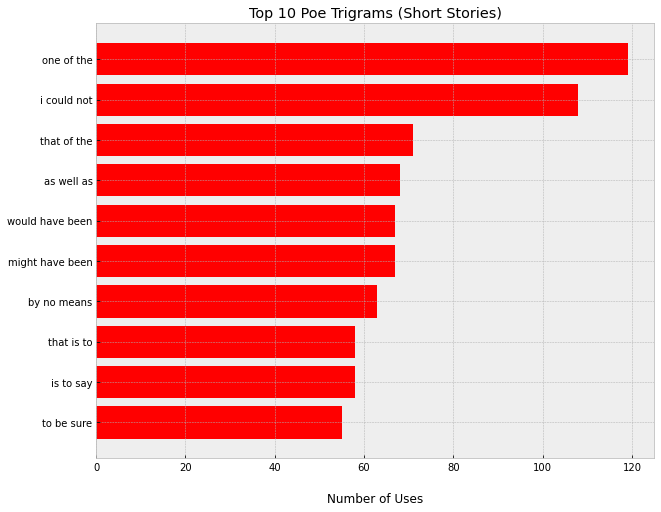

In [22]:
plot_top_ngrams(story_df.text, stop_words, title='Top 10 Poe Trigrams (Short Stories)', n=3)

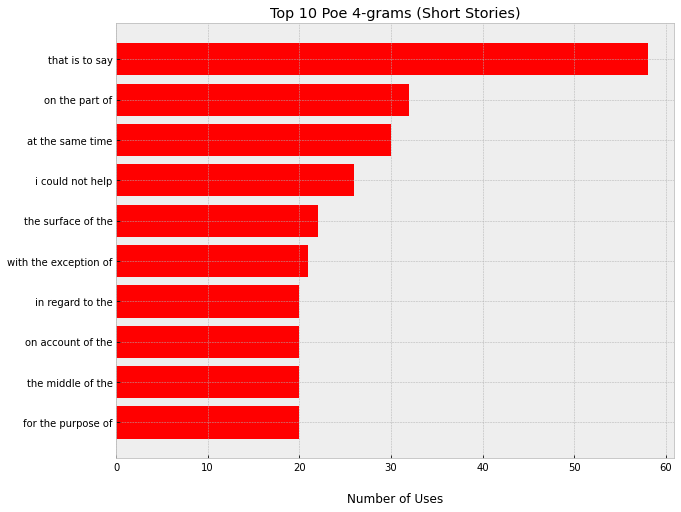

In [23]:
plot_top_ngrams(story_df.text, stop_words, title='Top 10 Poe 4-grams (Short Stories)', n=4)

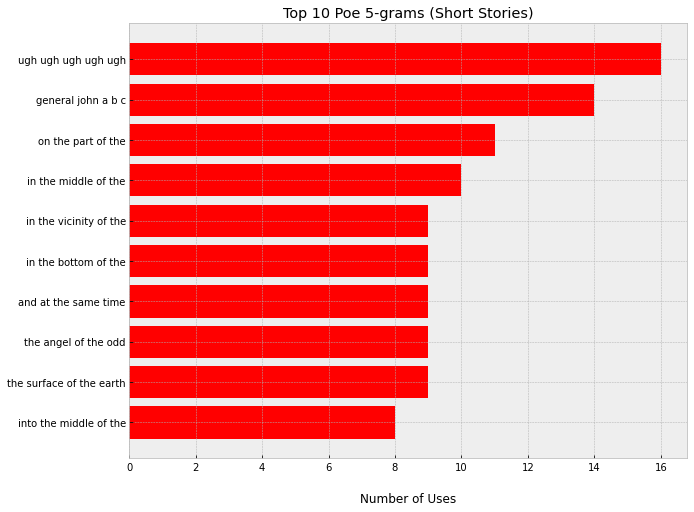

In [24]:
plot_top_ngrams(story_df.text, stop_words, title='Top 10 Poe 5-grams (Short Stories)', n=5)

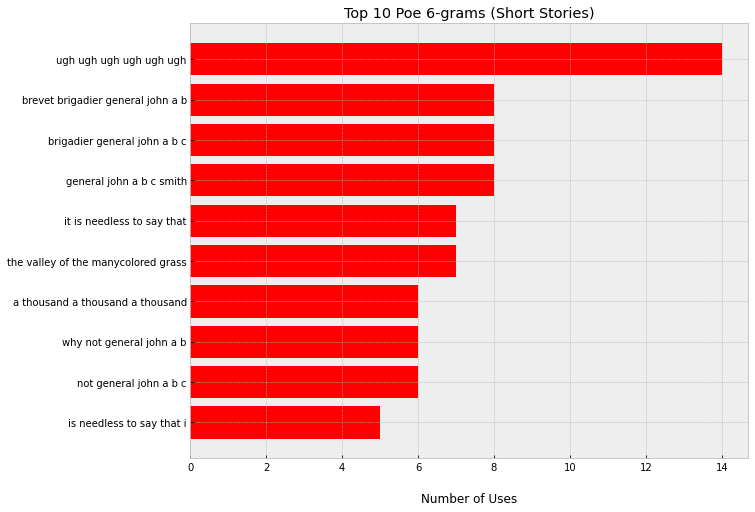

In [25]:
plot_top_ngrams(story_df.text, stop_words, title='Top 10 Poe 6-grams (Short Stories)', n=6)

### Sentence Word Counts

In [26]:
# helper function to split text by sentence prior to tokenization
# source - https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences

alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [27]:
def create_word_dist(text):
    sentences = split_into_sentences(text)
    word_counts = []
    for sentence in sentences:
        word_counts.append(len(clean_text(sentence).split(' ')))
    return word_counts

In [28]:
story_df['word_count_dist'] = story_df['text'].apply(create_word_dist)

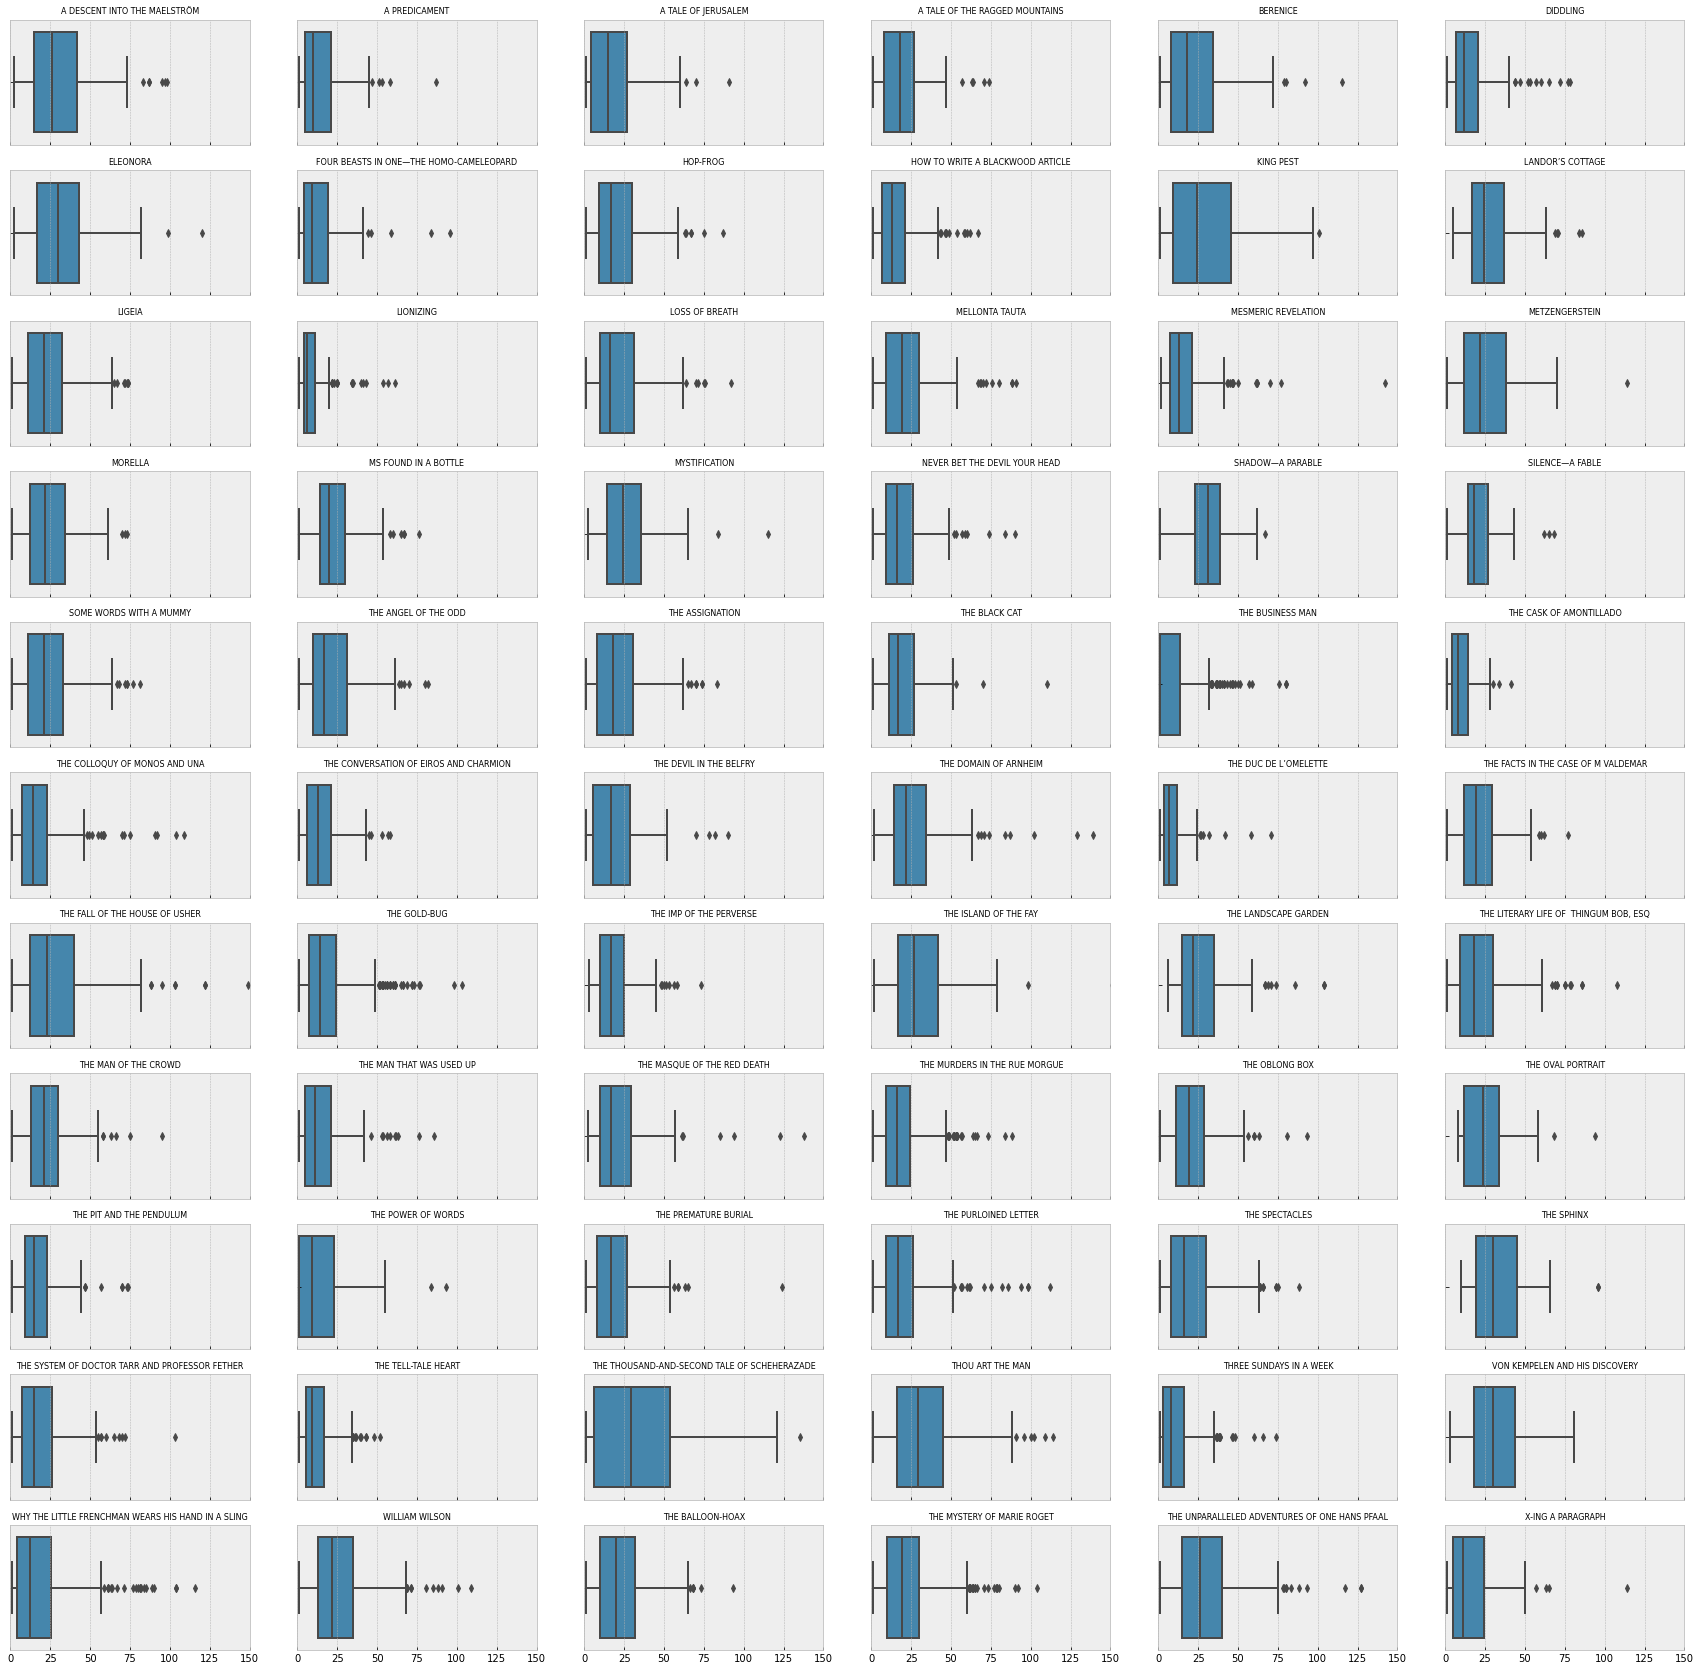

In [29]:
grid_rows = 11
grid_cols = 6

fig, ax = plt.subplots(grid_rows, grid_cols, sharex='col', figsize=(30,30))

story_index = 0

for row in range(grid_rows):
    for col in range(grid_cols):
        x_vals = story_df.iloc[story_index].word_count_dist
        story_title = story_df.iloc[story_index].title
        
        sns.boxplot(x=x_vals, ax=ax[row,col])
        ax[row,col].set_title(story_title, fontsize=8)
        ax[row,col].set_xlim(0, 150)
        story_index += 1
        
plt.show()



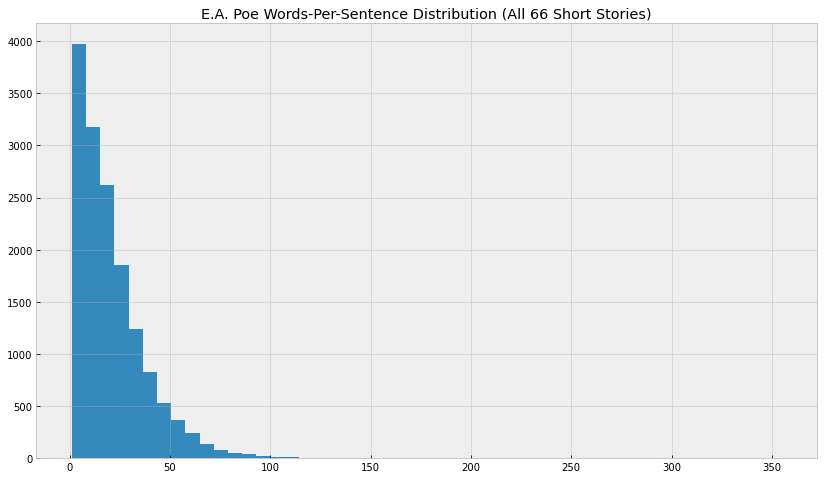

In [30]:
# combined texts
combined_word_counts = create_word_dist(combined_text)
    
fig, ax = plt.subplots(figsize=(14,8))
plt.hist(combined_word_counts, bins=50)
plt.title('E.A. Poe Words-Per-Sentence Distribution (All 66 Short Stories)')
plt.show()

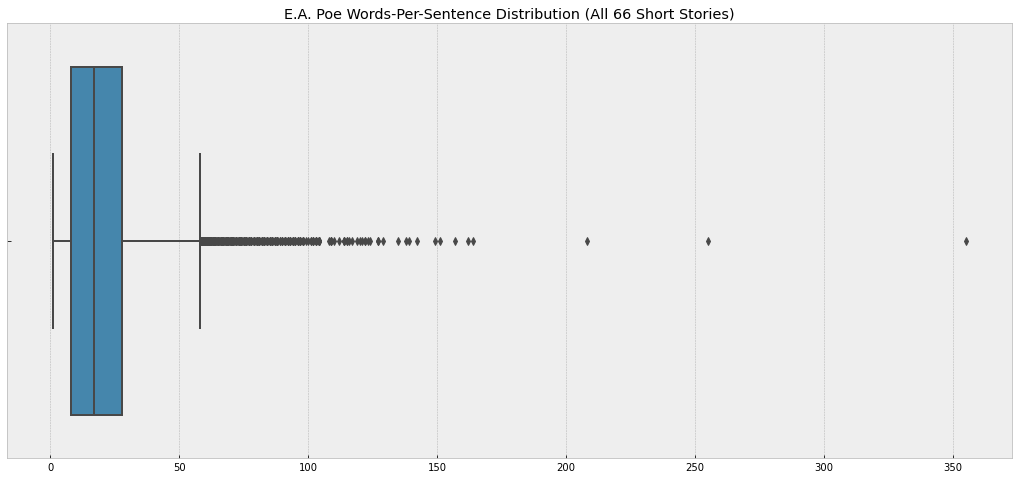

In [31]:
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot(combined_word_counts)
plt.title('E.A. Poe Words-Per-Sentence Distribution (All 66 Short Stories)')
plt.show()

## Poems
### Words Per Line

In [32]:
def word_count(text):
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    return len(text.split(' '))

In [33]:
poem_line_df['word_count'] = poem_line_df['line_text'].apply(word_count)

In [34]:
poem_stanza_df['word_count'] = poem_stanza_df['stanza_text'].apply(word_count)

In [35]:
poem_line_df['word_count'].describe()

count    2499.000000
mean        6.951581
std         3.368907
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        56.000000
Name: word_count, dtype: float64

In [36]:
poem_stanza_df['word_count'].describe()

count     215.000000
mean       78.813953
std        99.001146
min         9.000000
25%        35.000000
50%        57.000000
75%        84.000000
max      1113.000000
Name: word_count, dtype: float64

### Line & Stanza Distributions

In [37]:
poem_line_counts = poem_line_df.groupby('title').count()['line_text']
poem_stanza_counts = poem_stanza_df.groupby('title').count()['stanza_text']

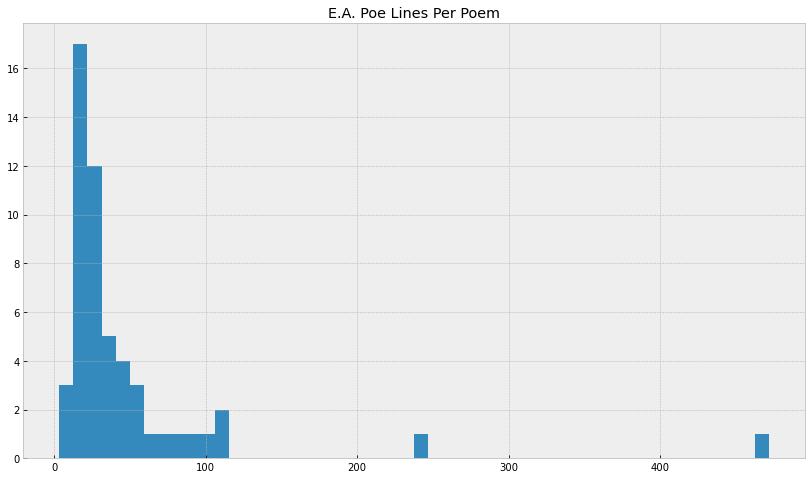

In [38]:
fig, ax = plt.subplots(figsize=(14,8))
plt.hist(poem_line_counts, bins=50)
plt.title('E.A. Poe Lines Per Poem')
plt.show()

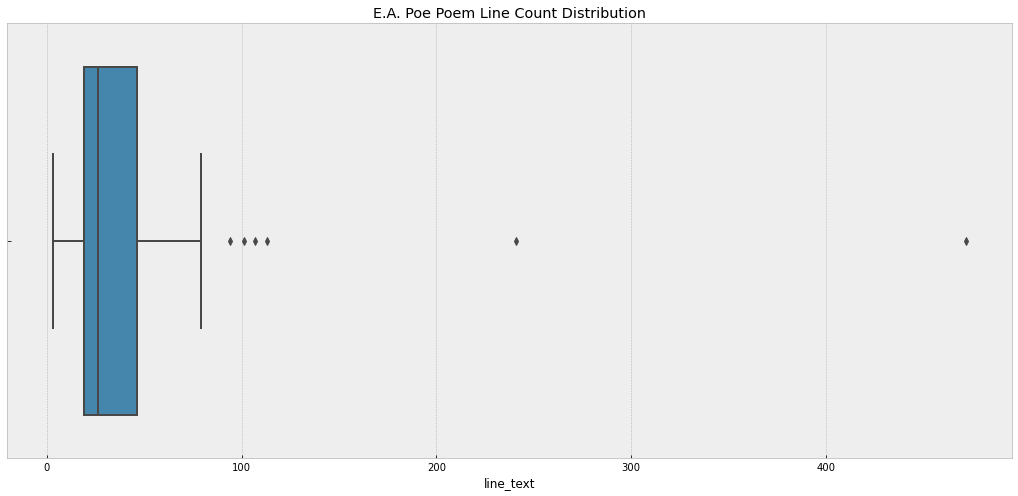

In [39]:
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot(poem_line_counts)
plt.title('E.A. Poe Poem Line Count Distribution')
plt.show()

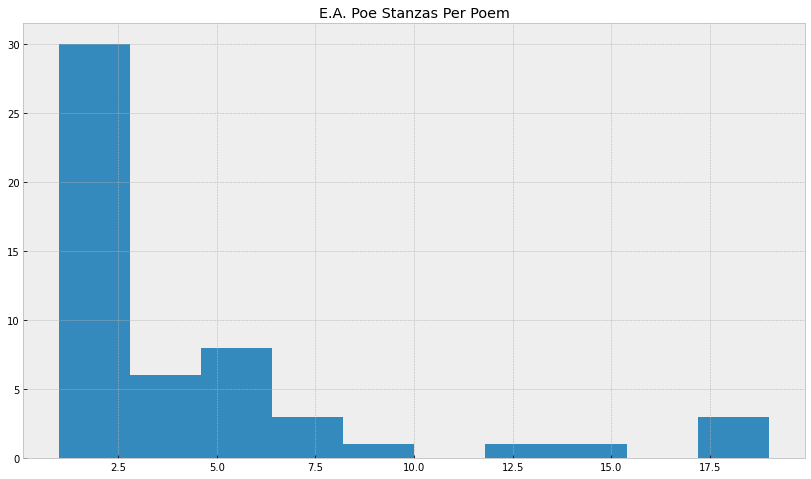

In [40]:
fig, ax = plt.subplots(figsize=(14,8))
plt.hist(poem_stanza_counts, bins=10)
plt.title('E.A. Poe Stanzas Per Poem')
plt.show()

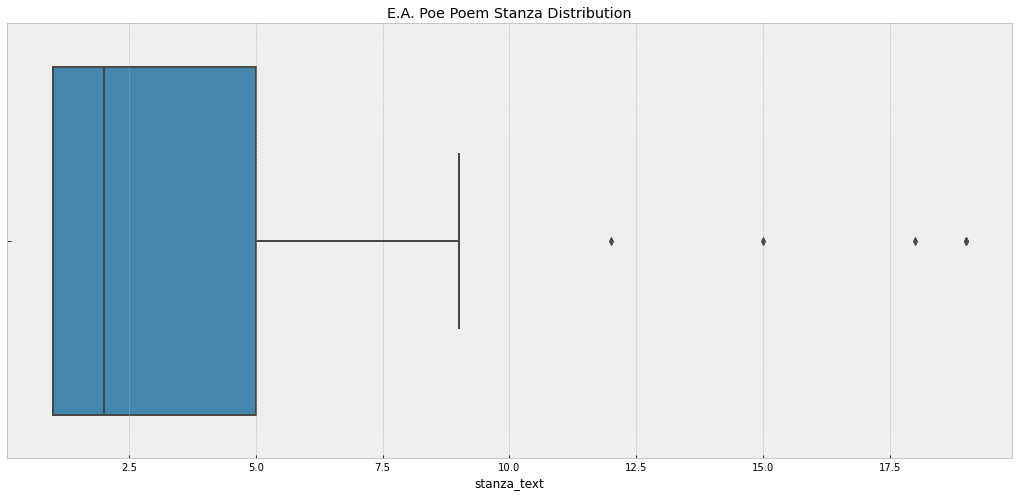

In [41]:
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot(poem_stanza_counts)
plt.title('E.A. Poe Poem Stanza Distribution')
plt.show()

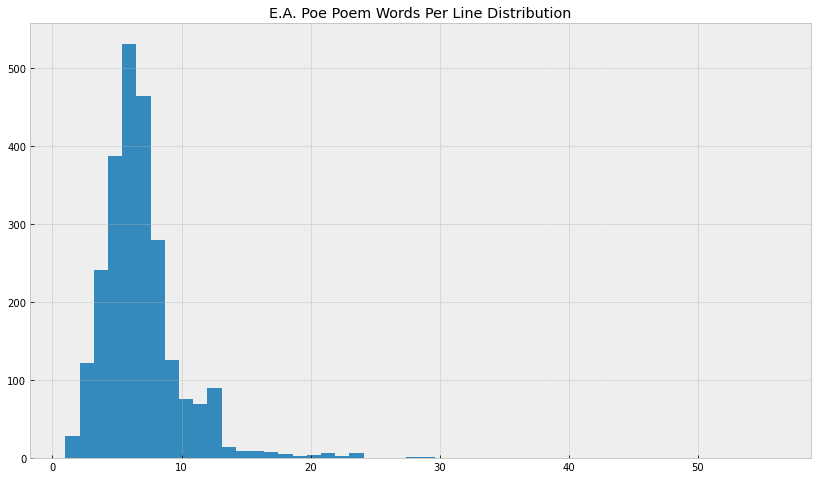

In [42]:
fig, ax = plt.subplots(figsize=(14,8))
plt.hist(poem_line_df['word_count'], bins=50)
plt.title('E.A. Poe Poem Words Per Line Distribution')
plt.show()

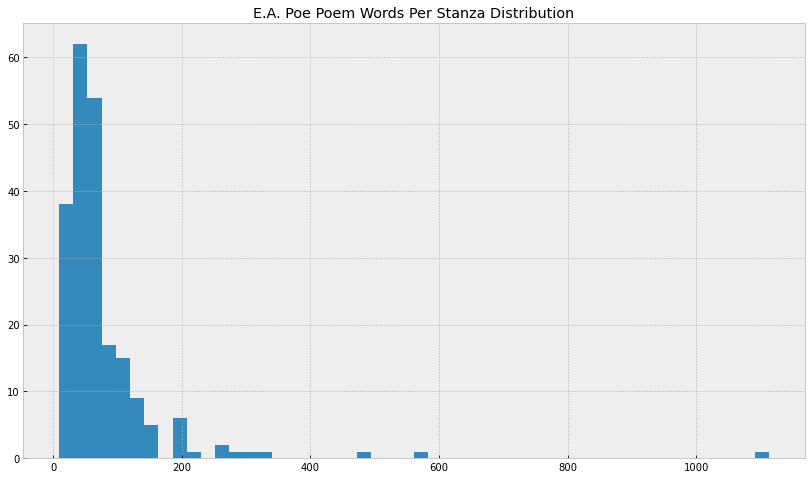

In [43]:
fig, ax = plt.subplots(figsize=(14,8))
plt.hist(poem_stanza_df['word_count'], bins=50)
plt.title('E.A. Poe Poem Words Per Stanza Distribution')
plt.show()